In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0, '../')
import pandas as pd
import tqdm
import pickle

import vis
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
### Configure file and folder names
data_feather = "../data/soccermix_J1_all_data.feather"

models = "../data/soccermix_J1_models.pkl"
c_weights = "../data/soccermix_J1_all_catweights.pkl"
l_weights = "../data/soccermix_J1_all_locweights.pkl"
d_weights = "../data/soccermix_J1_all_dirweights.pkl"

In [3]:
def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

items = loadall(models)
d_w = loadall(d_weights)

In [4]:
cat_model = next(items)
loc_models = next(items)
dir_models = next(items)
dir_weights = next(d_w)

In [5]:
X = pd.read_feather(data_feather)
games = pd.read_feather('../data/JL_games.feather')
teams = pd.read_feather('../data/JL_teams.feather')
players = pd.read_feather('../data/JL_players.feather')
pg = pd.read_feather('../data/JL_player_games.feather')
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

japan_id_map = dict(zip(games["home_team_name"], games["home_team_id"]))
merged_weights = dir_weights.copy()
merged_weights["team_id"] = X.team_id.values
merged_weights["game_id"] = X.game_id.values
merged_weights["player_id"] = X.player_id.values


상대가 달라질때마다 팀의 전술이 얼마나 달라지는지 계산

In [ ]:

vectors = {}
set_teams = set(merged_weights.team_id.astype('int'))

for p in tqdm.tqdm(list(merged_weights.team_id.unique())):
    other_teams = set_teams - {int(p)}
    for p2 in other_teams:
        remaining_teams = other_teams - {p2}
        
        A_B_games = games[((( (games.away_team_id == p) & (games.home_team_id == p2)) 
                          |( (games.away_team_id == p2) & (games.home_team_id == p)))
                          )].game_id.values
                
        B_other_games = games[((( (games.away_team_id == p2) & (games.home_team_id.isin(remaining_teams)) )
                              | ((games.away_team_id.isin(remaining_teams)) & (games.home_team_id == p2)))
                              )].game_id.values
        
        
        vec1 = merged_weights.loc[((merged_weights.game_id.isin(A_B_games)) 
                                  & (merged_weights.team_id == p2)), dir_weights.columns].sum().values
        vec1 /= 2
            
        
        vec2 = merged_weights.loc[((merged_weights.game_id.isin(B_other_games))
                                  & (merged_weights.team_id == p2)), dir_weights.columns].sum().values
        vec2 /= 38
        
        vectors[f'{int(p)}_{int(p2)}_0'] = vec1 #vector of team 2 when playing only against team 1
        vectors[f'{int(p)}_{int(p2)}_1'] = vec2 #vector of team 2 when playing against all other teams except team 1

100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


In [12]:
vectors_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors.items()}).droplevel(level=1)
vectors_pd.index.name = "team_game"
vectors_pd.columns = dir_weights.columns

In [13]:
def show_vectors(team_id, set_teams, teams, vectors_pd):
    other_teams = set_teams - {int(team_id)}
    for p2 in other_teams:
        print(teams[teams.team_id == team_id].team_name.values[0] + "-" + teams[teams.team_id == p2].team_name.values[0])
        sli = vectors_pd.loc[vectors_pd.index.str.contains(f'^{int(team_id)}_{int(p2)}_')]
        plt.figure(figsize=(50,10))
        plt.plot(vectors_pd.columns.values, sli.iloc[0,:].values, 'r') 
        plt.plot(vectors_pd.columns.values, sli.iloc[1,:].values, 'b')
        plt.show()

In [14]:
def get_mean_difference_vector(team):
    differences = []
    for t in set_teams:
        if (t != team):
            differences.append(vectors_pd.loc[f"{team}_{int(t)}_0"] - vectors_pd.loc[f"{team}_{int(t)}_1"])
            # difference between how team t plays against 'team' and how team t play against all other teams
            
    mean_vector = np.mean(differences, 0)
    mean_pd = pd.DataFrame(columns=vectors_pd.columns.values)
    mean_pd.loc[0] = mean_vector
    mean_pd.loc[1] = np.zeros_like(mean_vector)
    
    return mean_pd

### Defensive style of Machida Zelvia
- 2024시즌 J리그 최소실점 팀

In [11]:
print(teams[teams.team_name == 'FC Machida Zelvia'].team_id)

3    4609
Name: team_id, dtype: int64


FC Machida Zelvia-Albirex Niigata


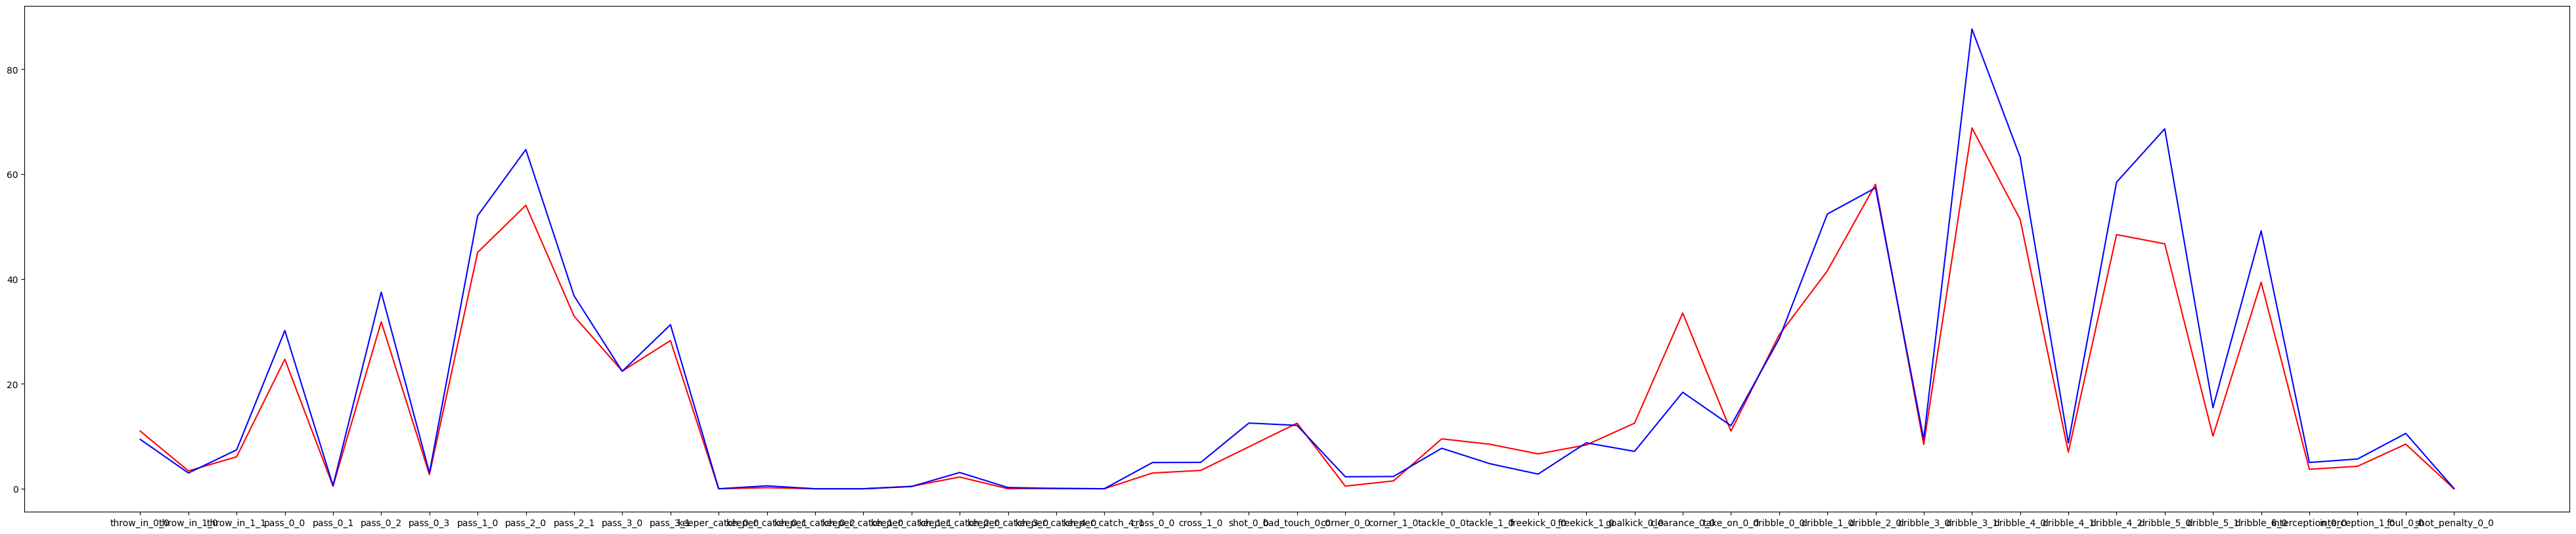

FC Machida Zelvia-Kyoto Sanga FC


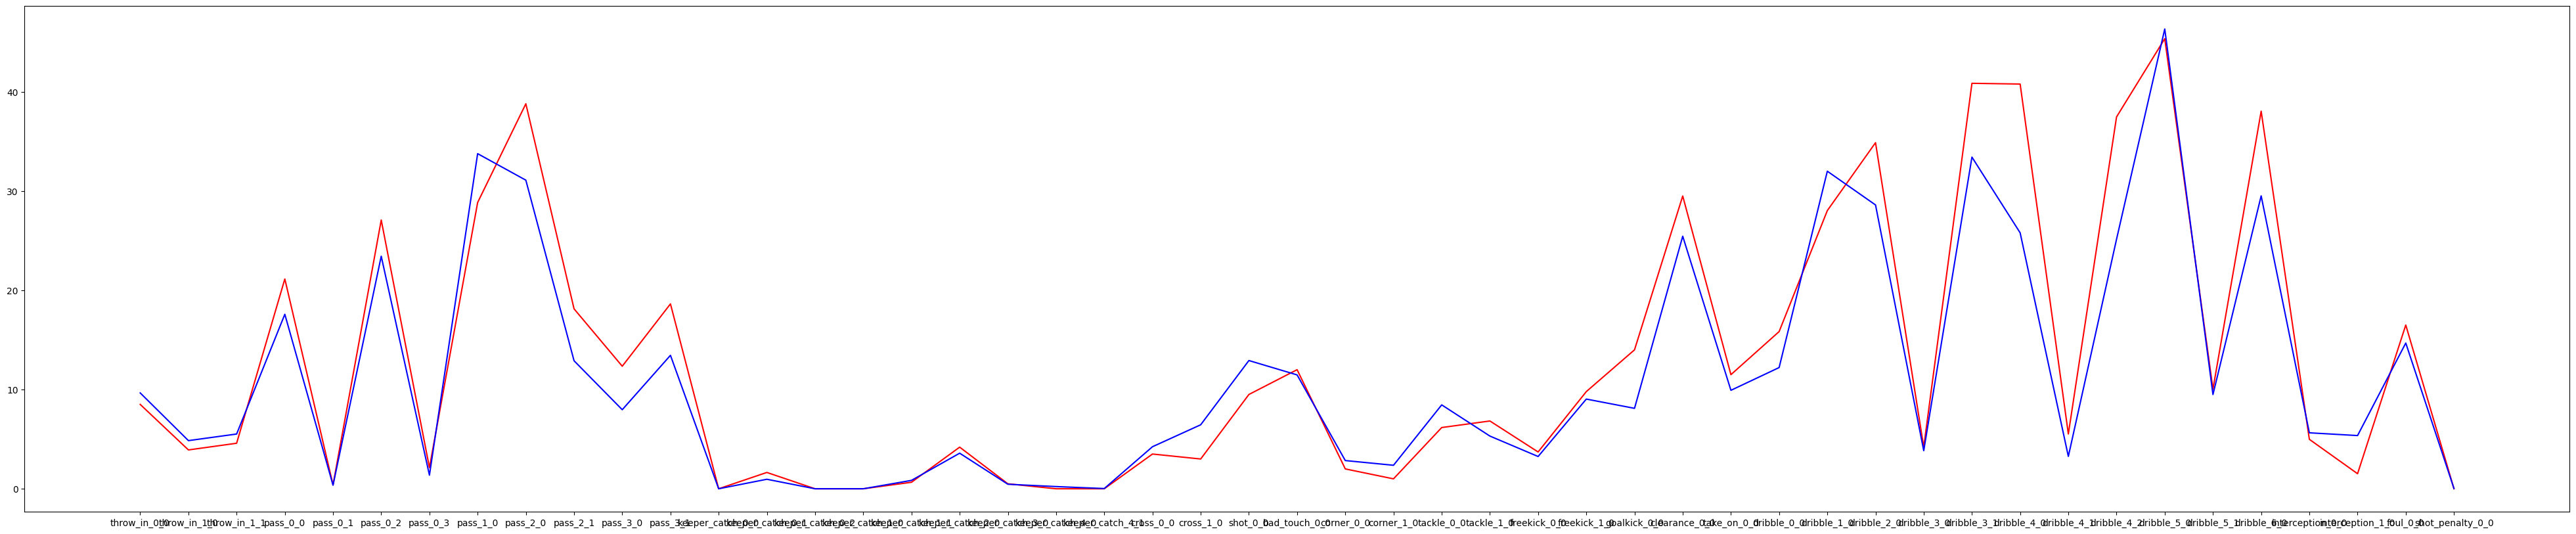

FC Machida Zelvia-Yokohama F. Marinos


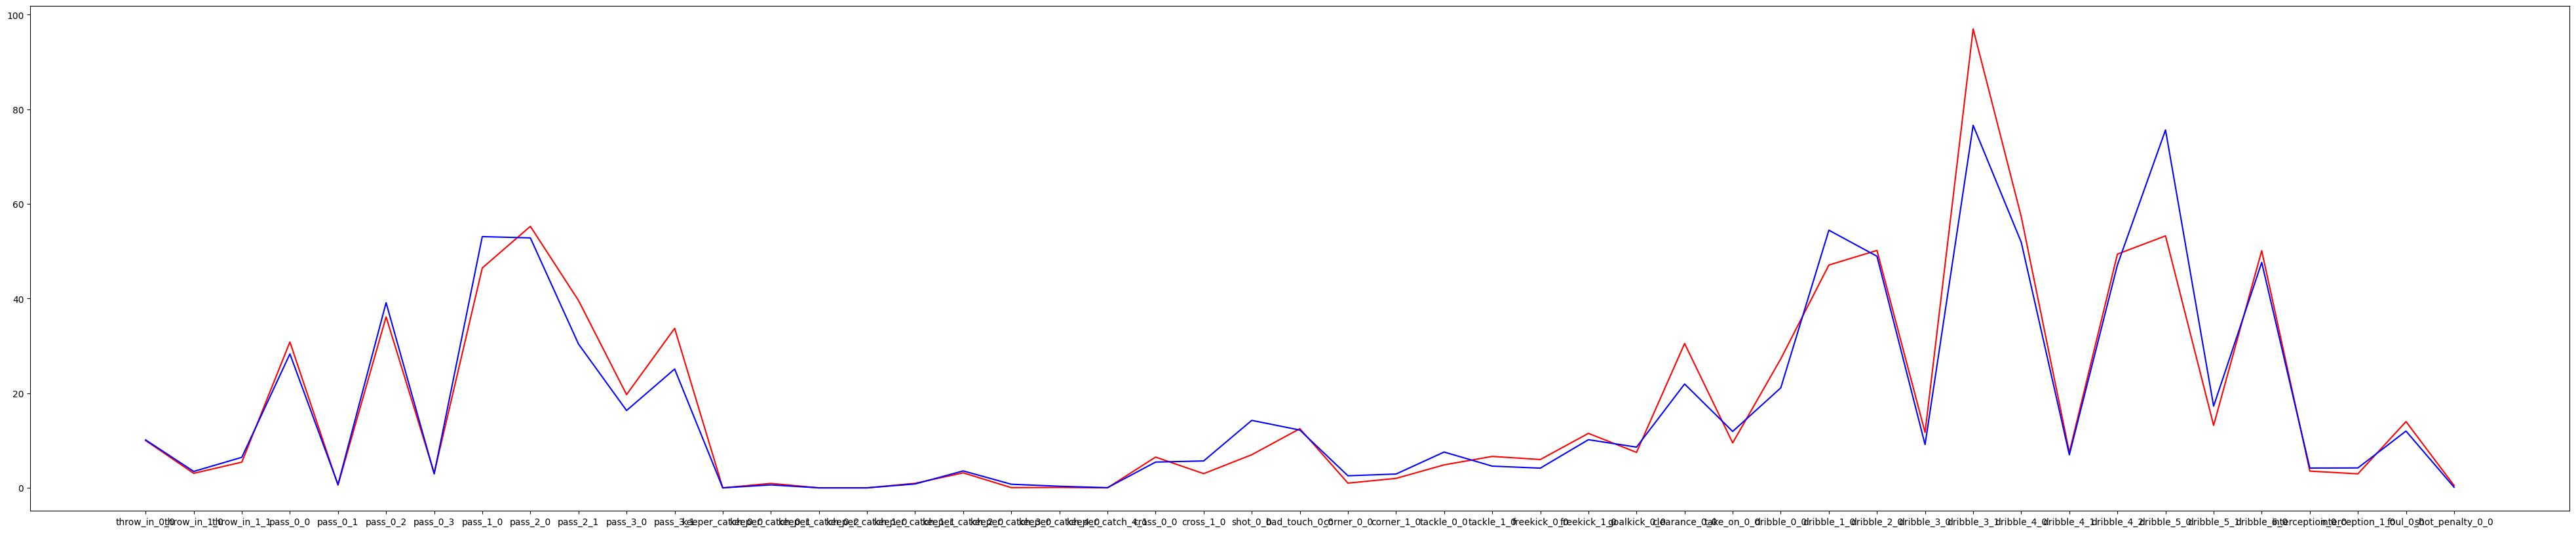

FC Machida Zelvia-Kashima Antlers


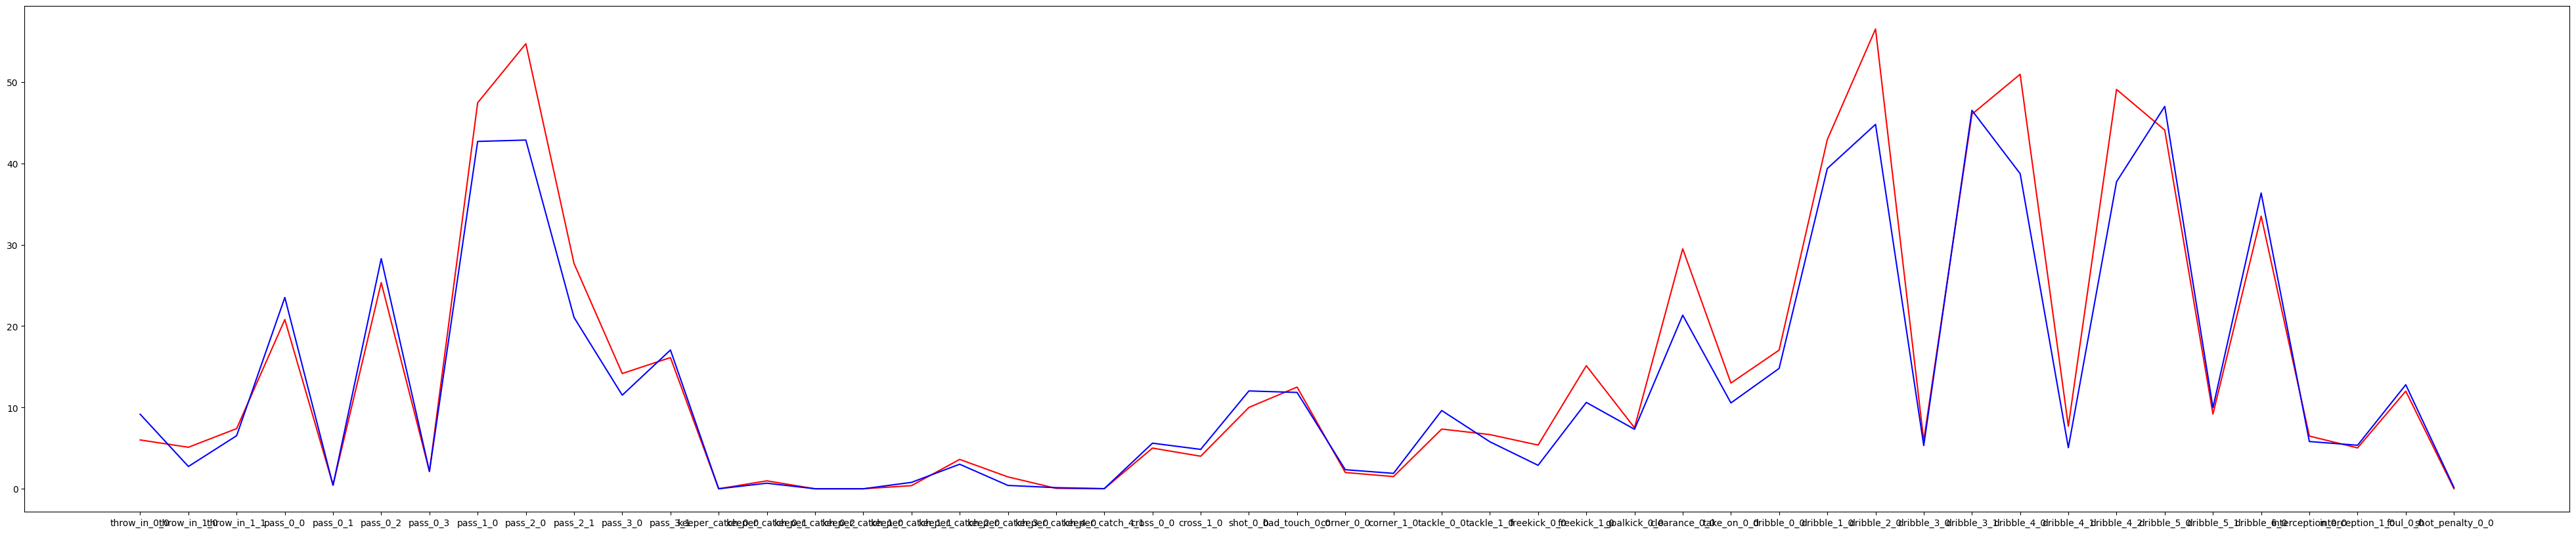

FC Machida Zelvia-Urawa Reds


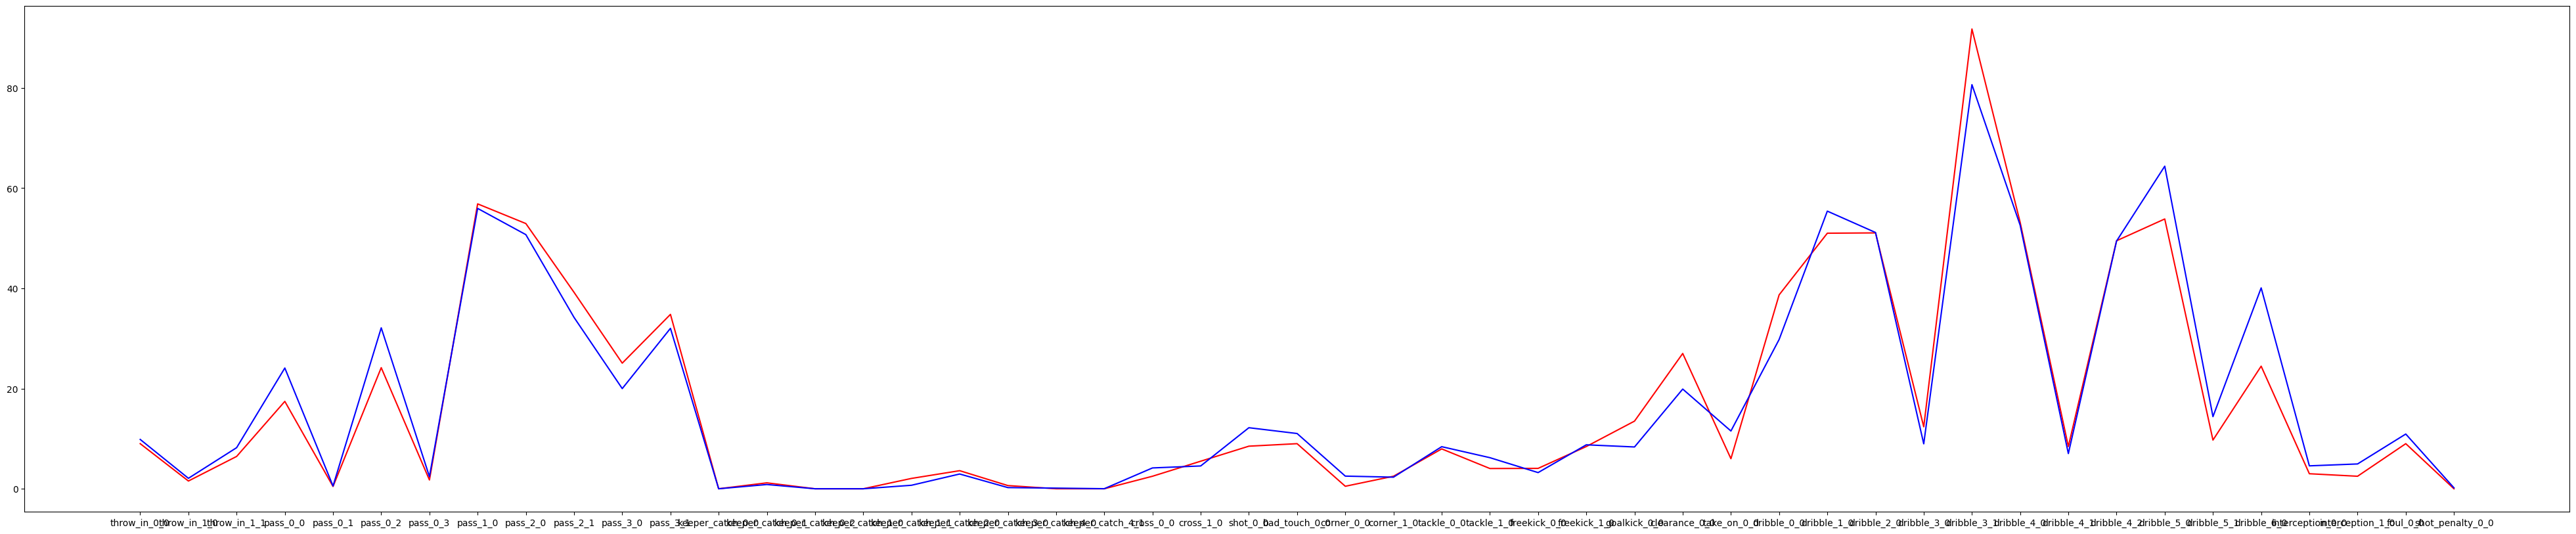

FC Machida Zelvia-Nagoya Grampus


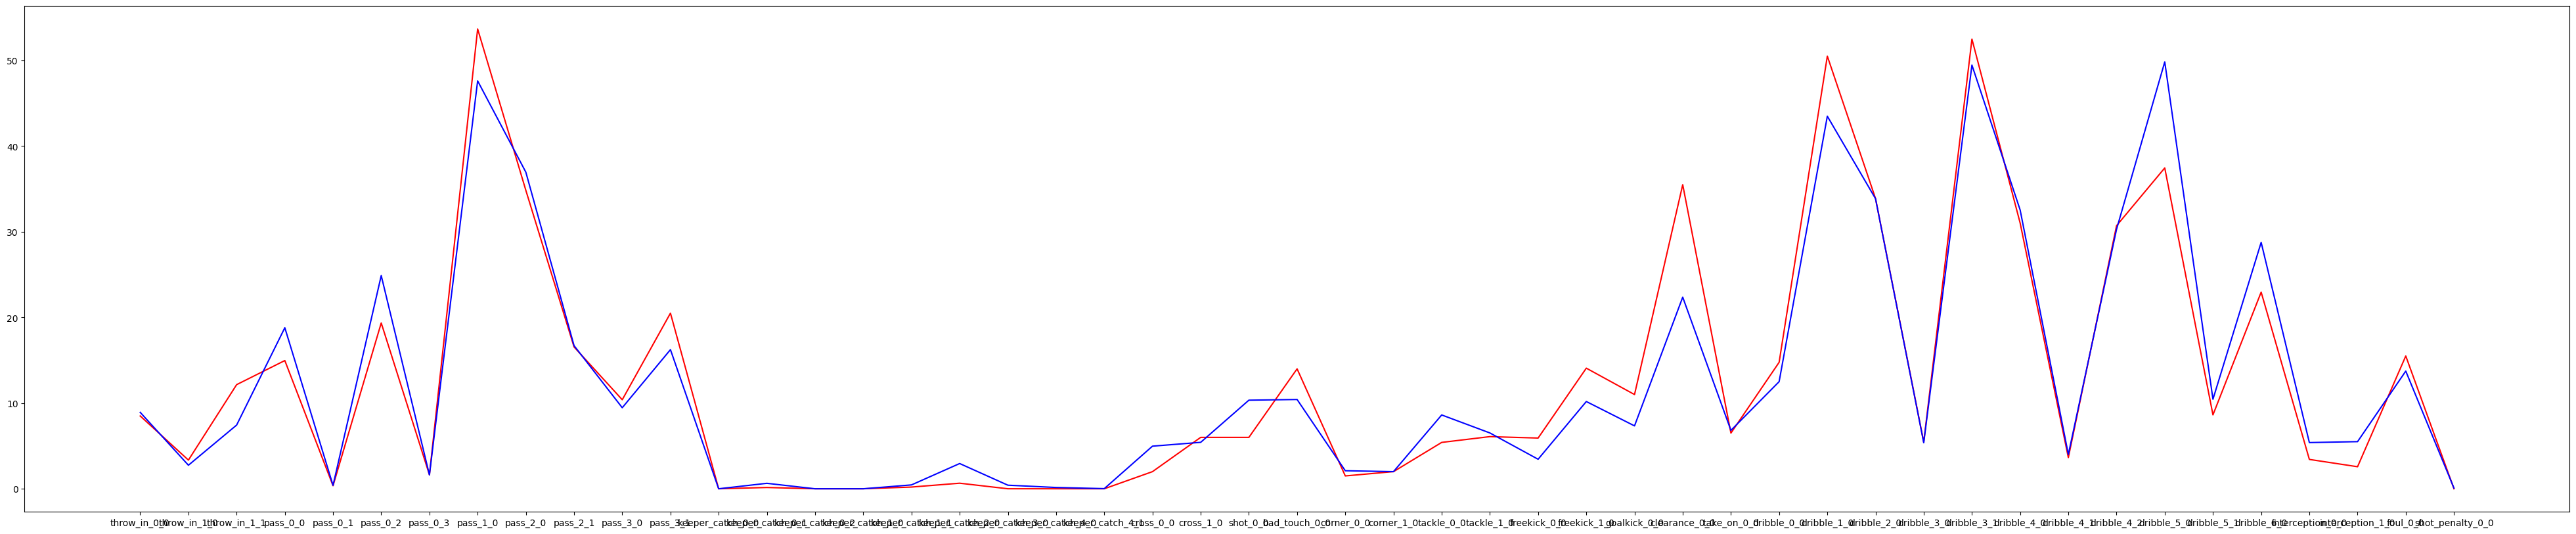

FC Machida Zelvia-Gamba Osaka


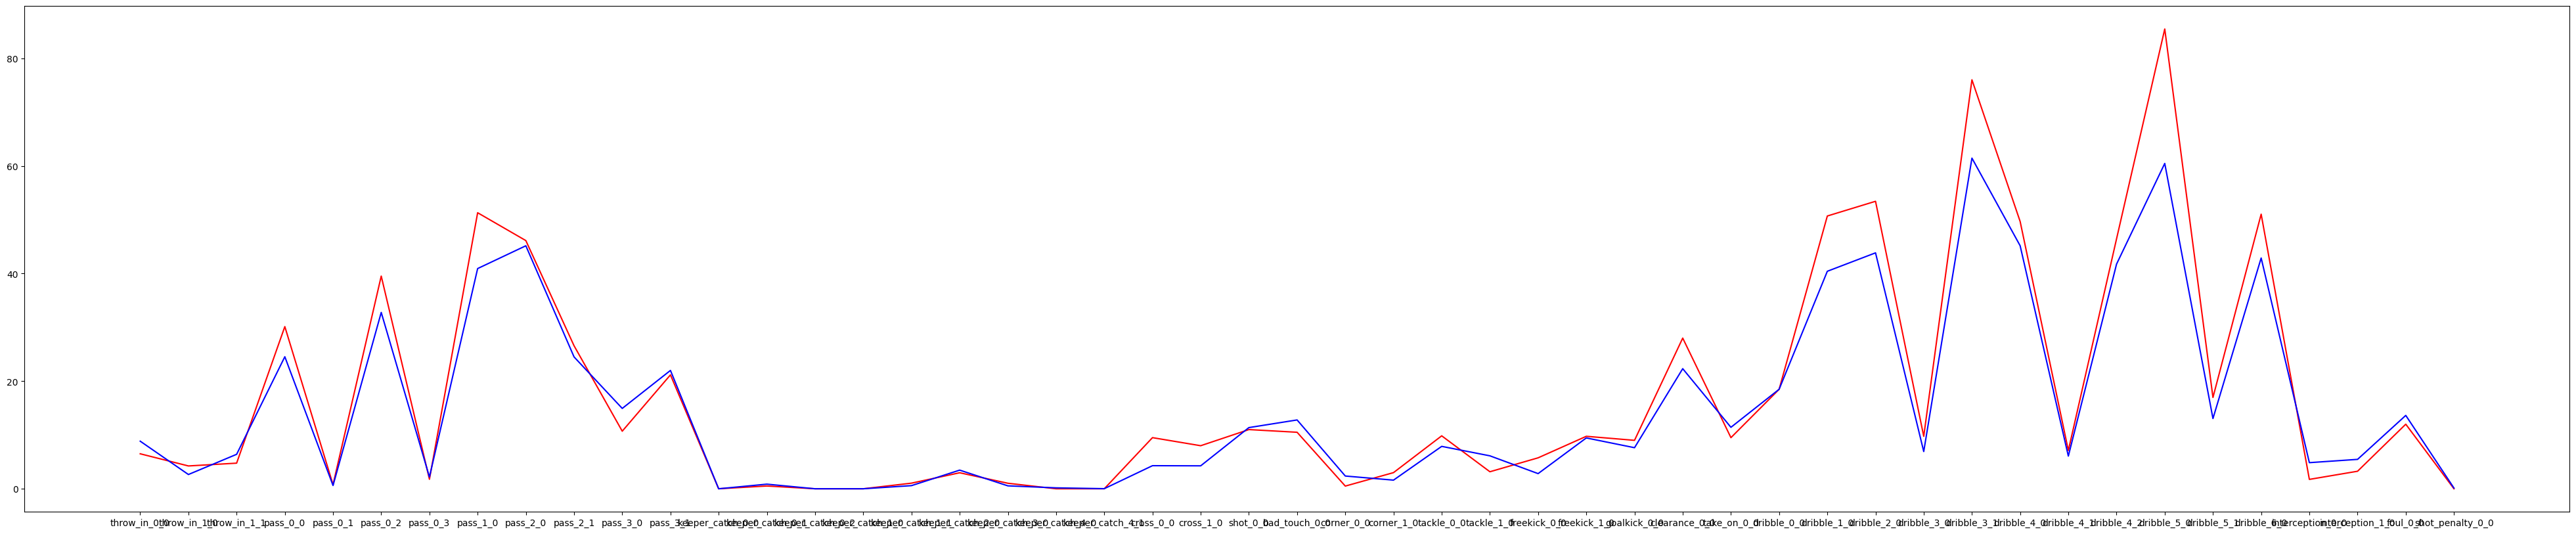

FC Machida Zelvia-Vissel Kobe


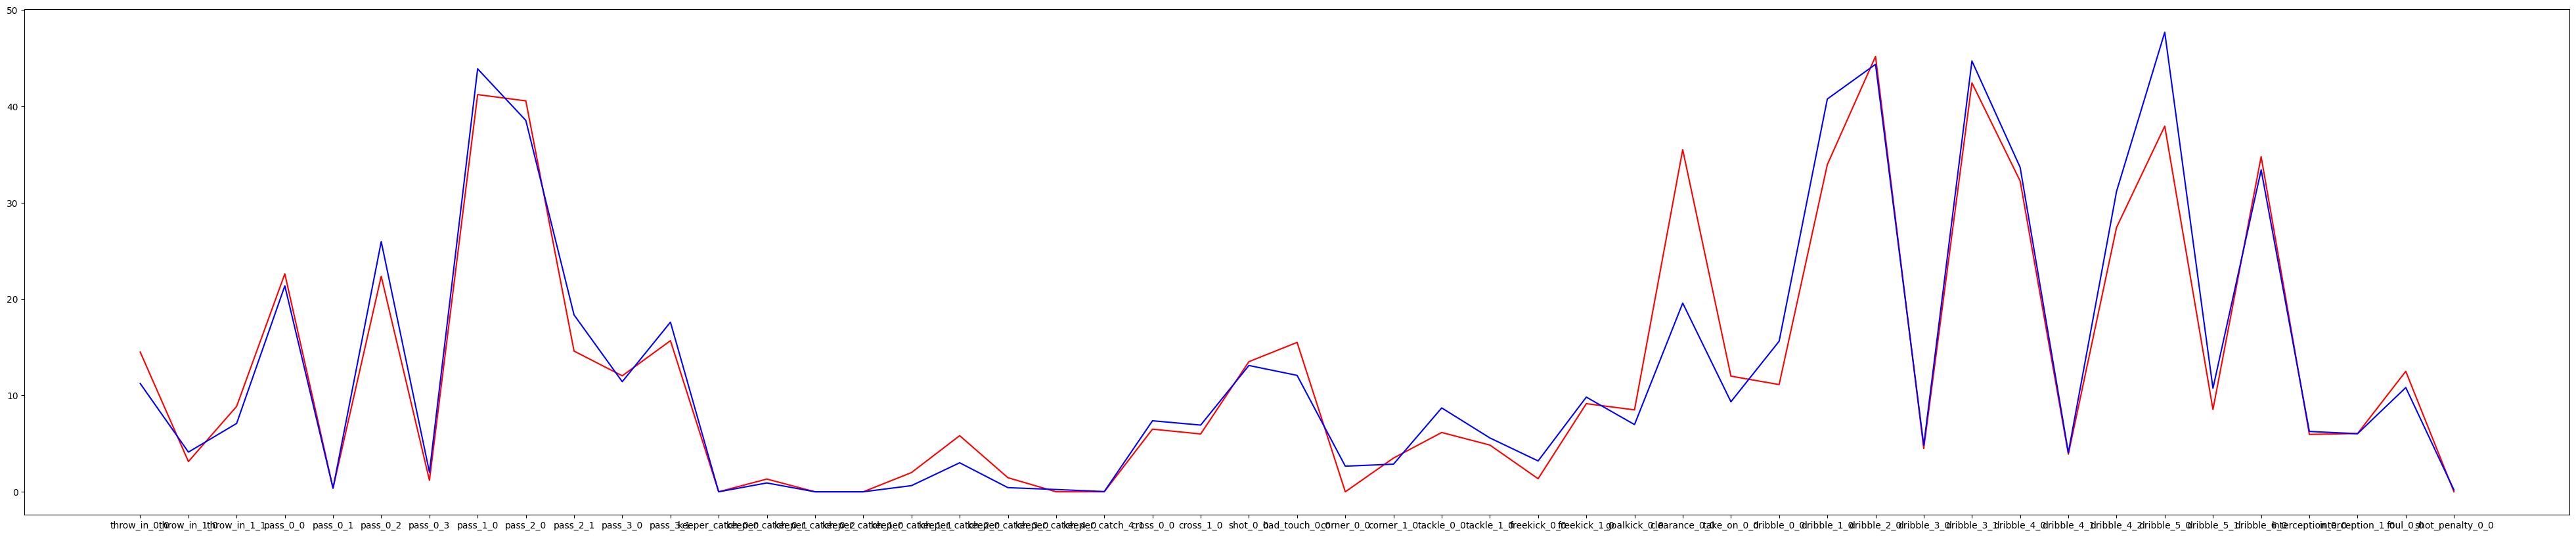

FC Machida Zelvia-Tokyo


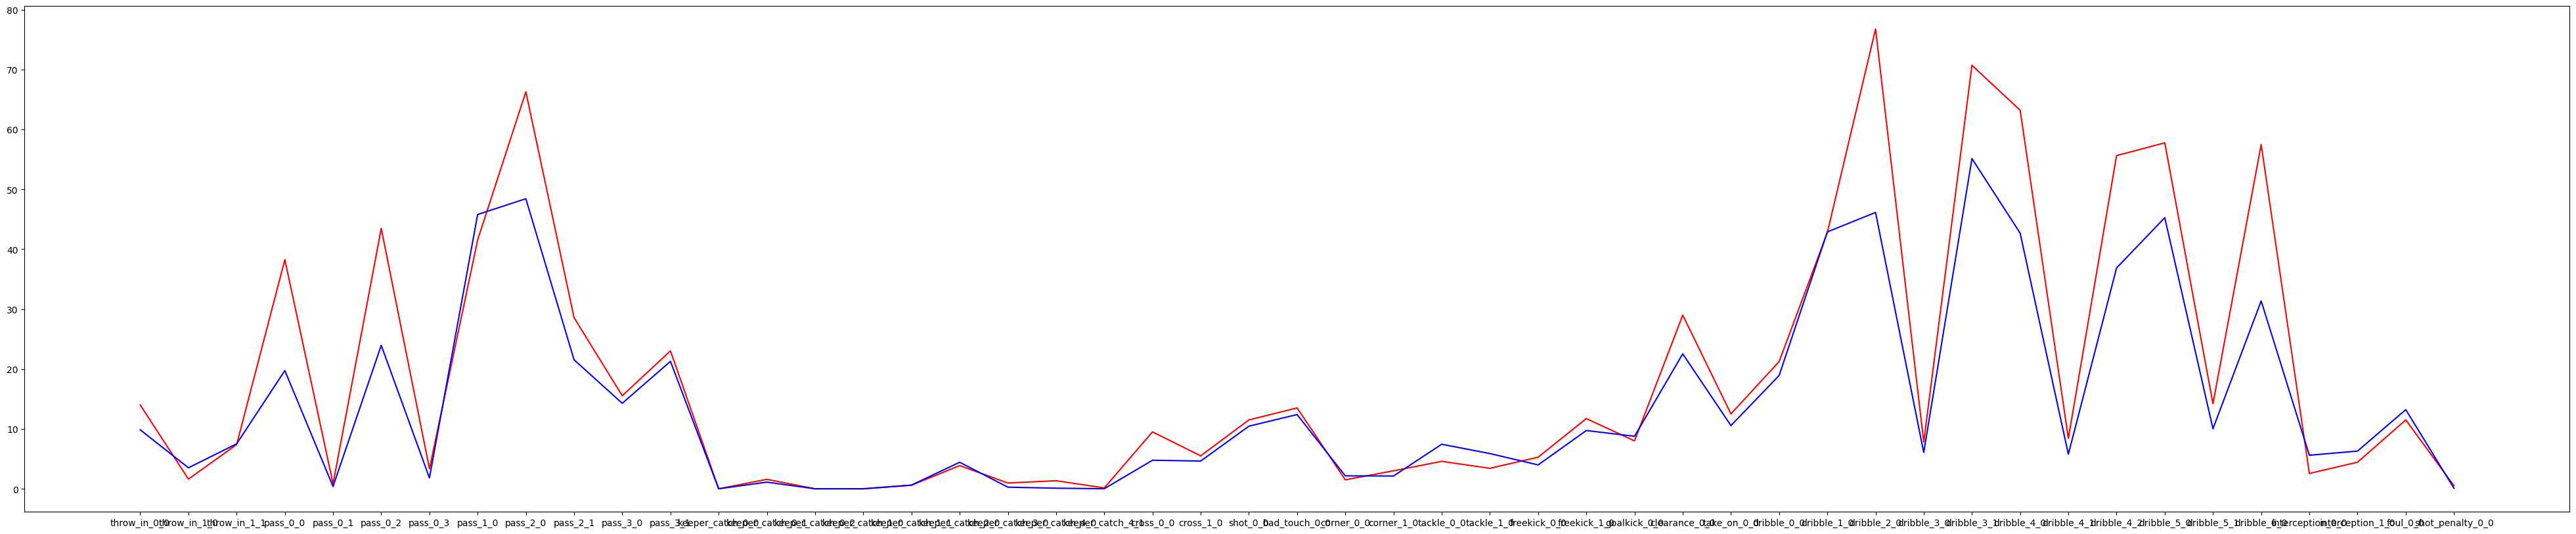

FC Machida Zelvia-Sanfrecce Hiroshima


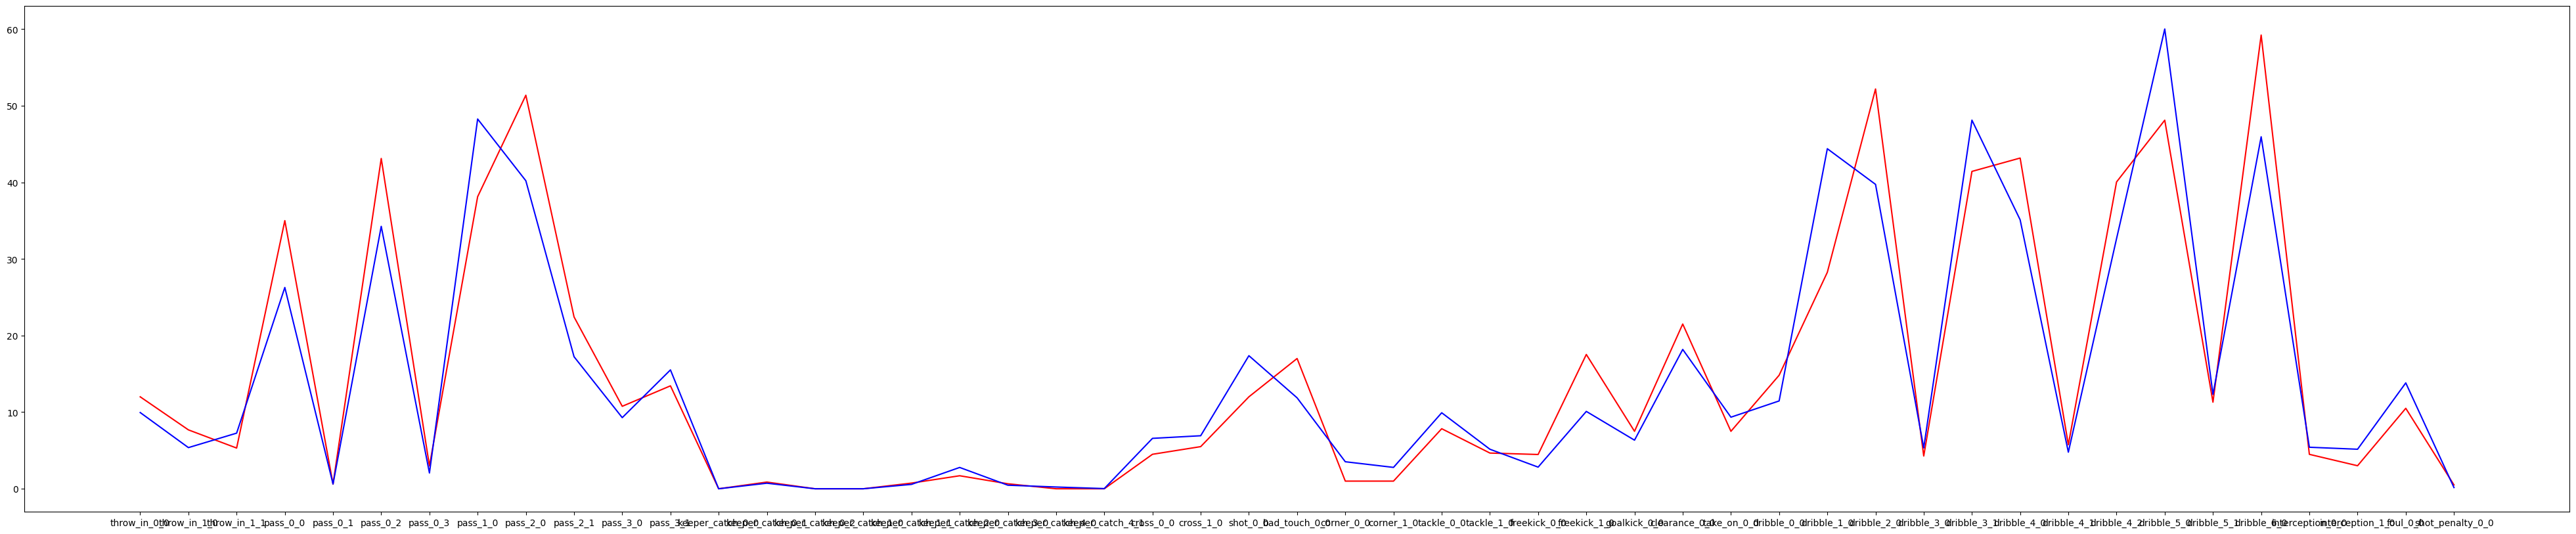

FC Machida Zelvia-Kashiwa Reysol


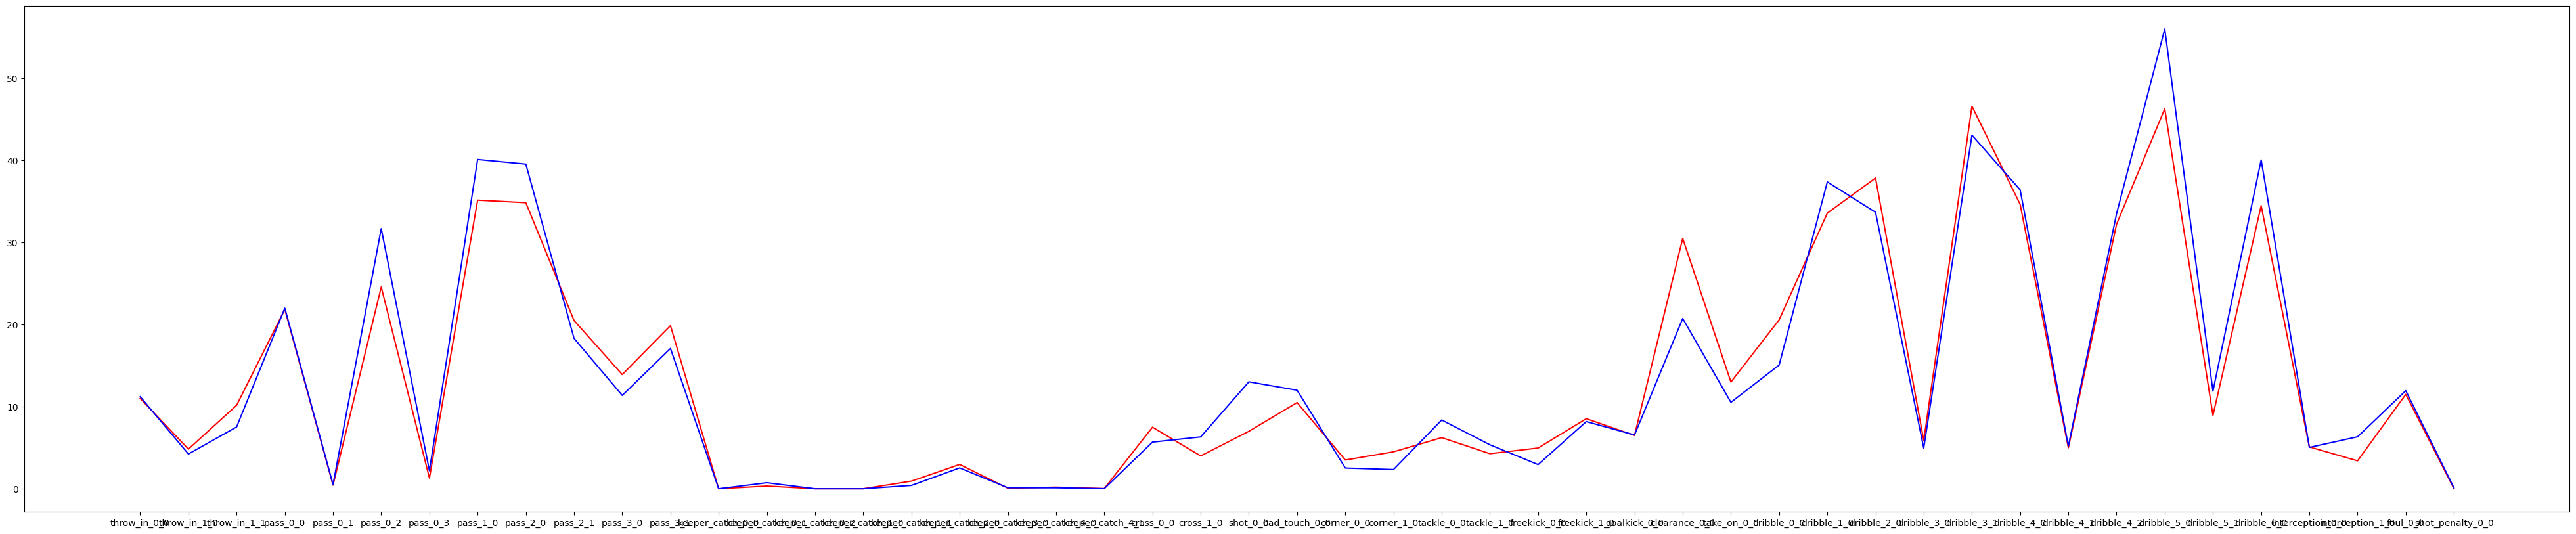

FC Machida Zelvia-Cerezo Osaka


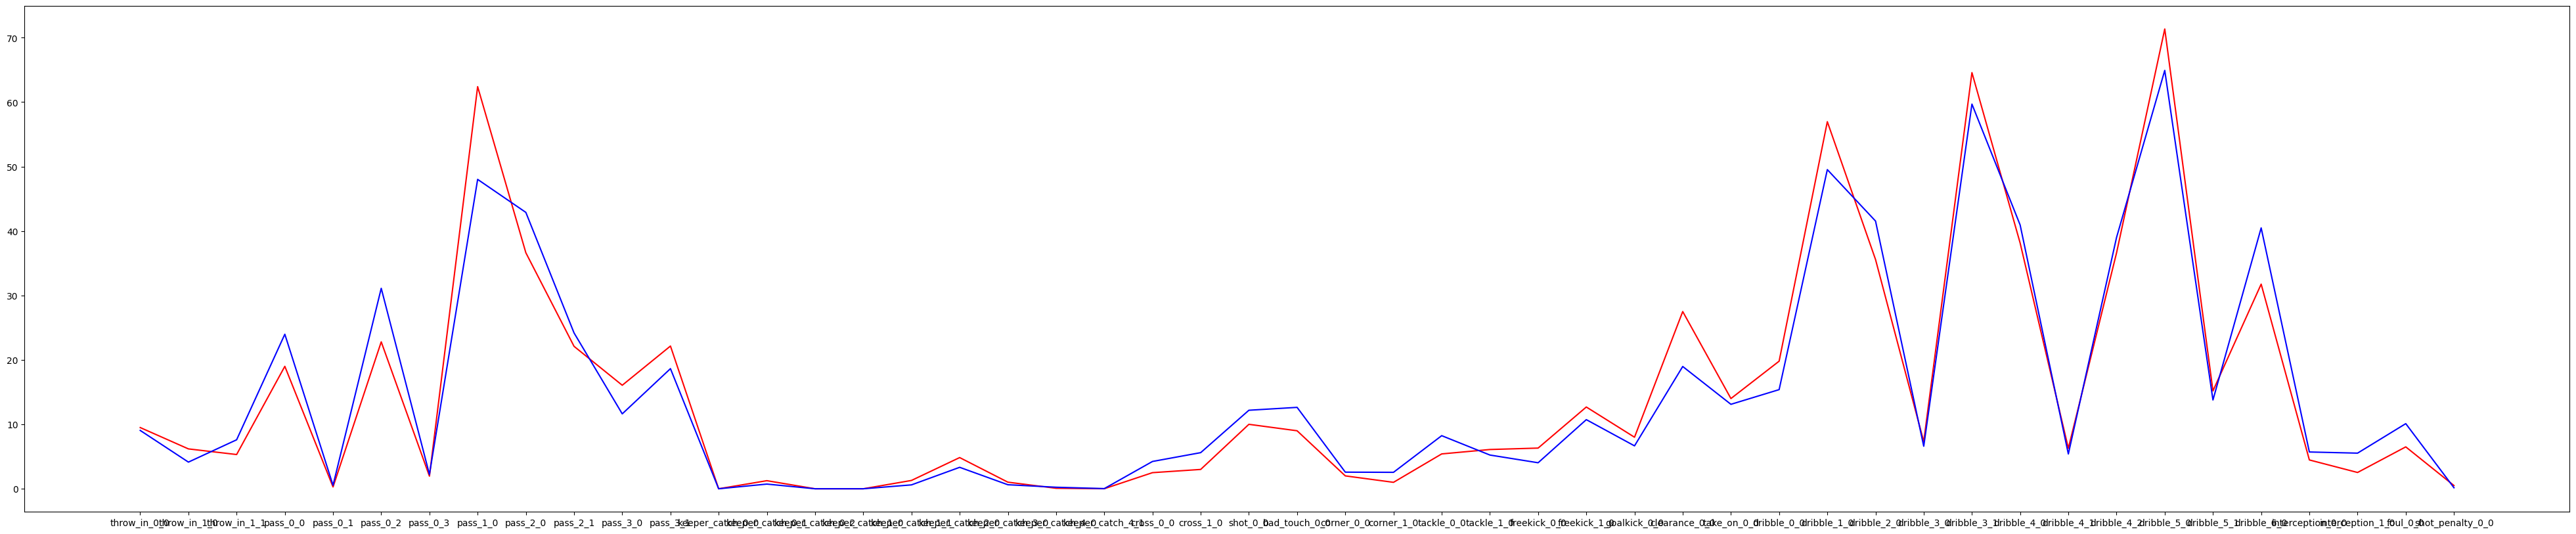

FC Machida Zelvia-Avispa Fukuoka


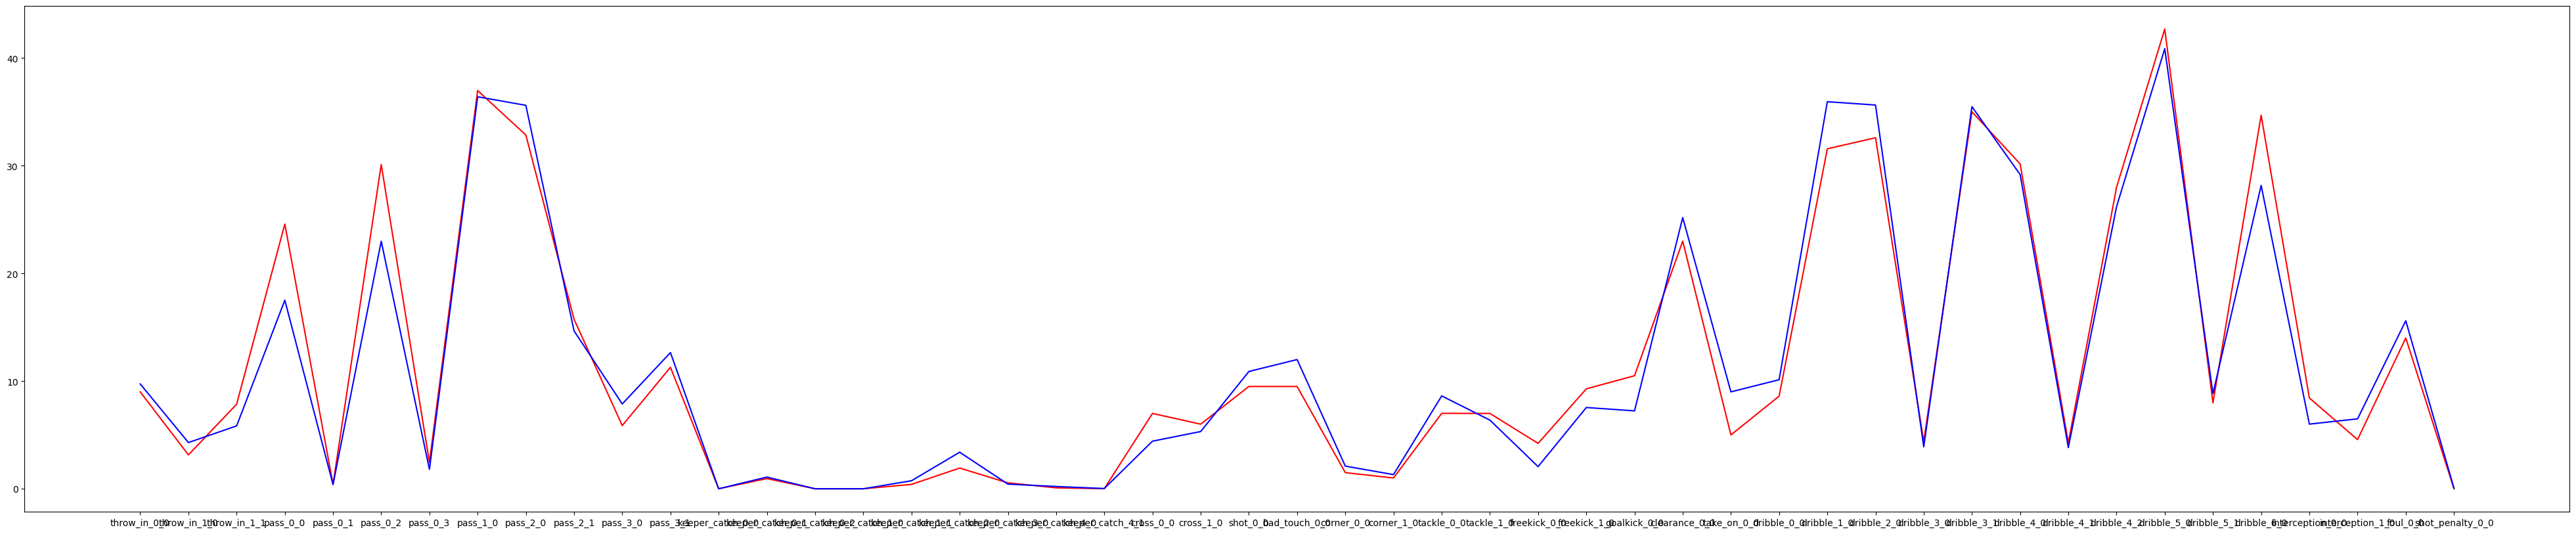

FC Machida Zelvia-Kawasaki Frontale


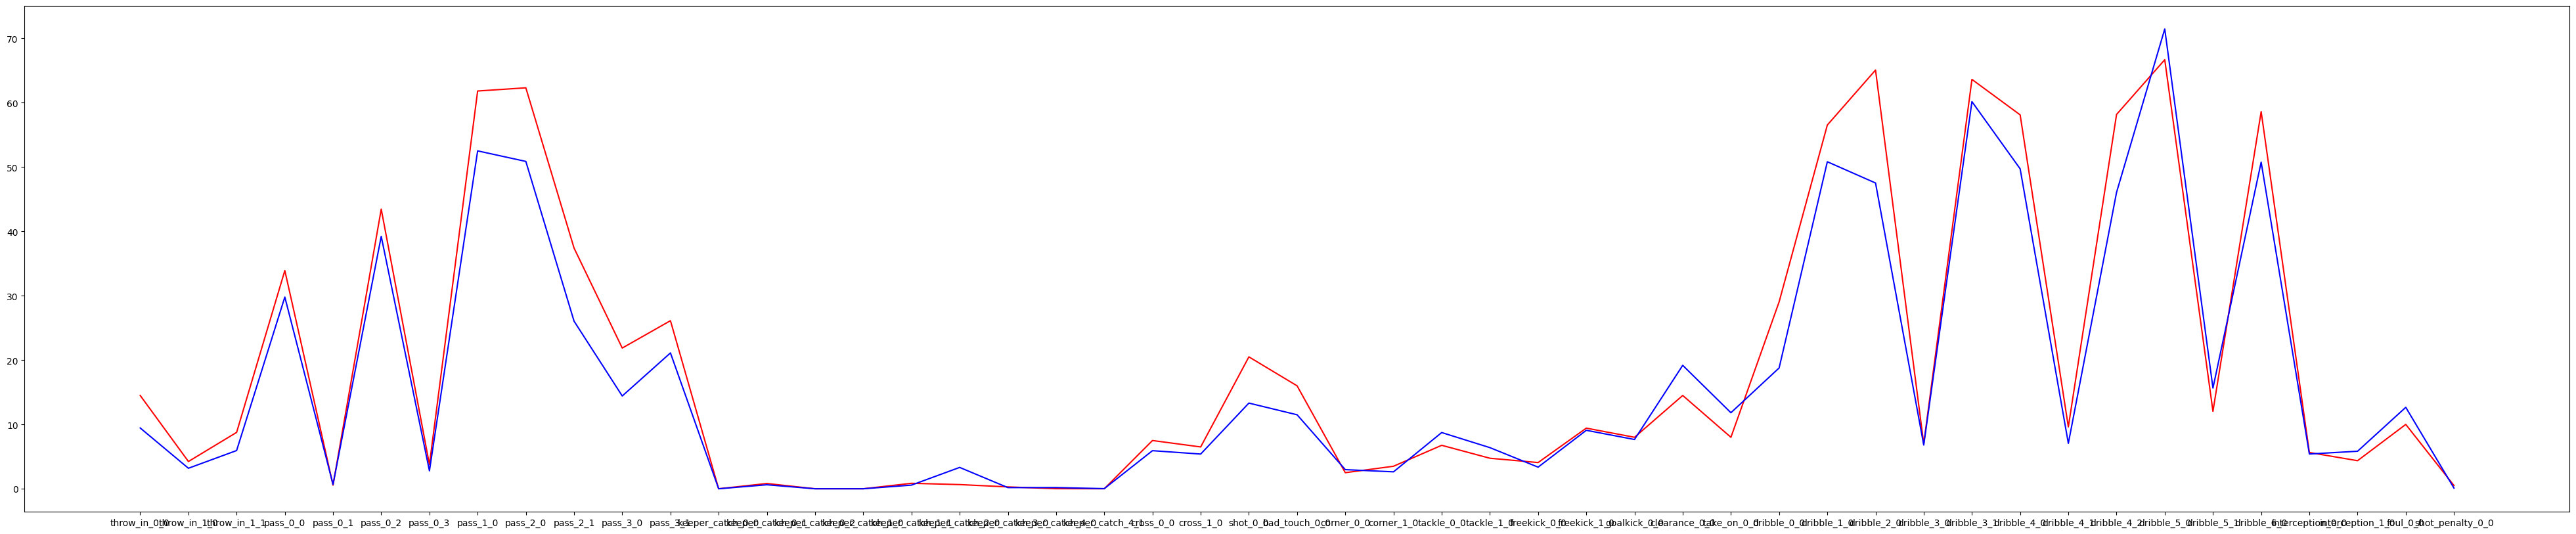

FC Machida Zelvia-Sagan Tosu


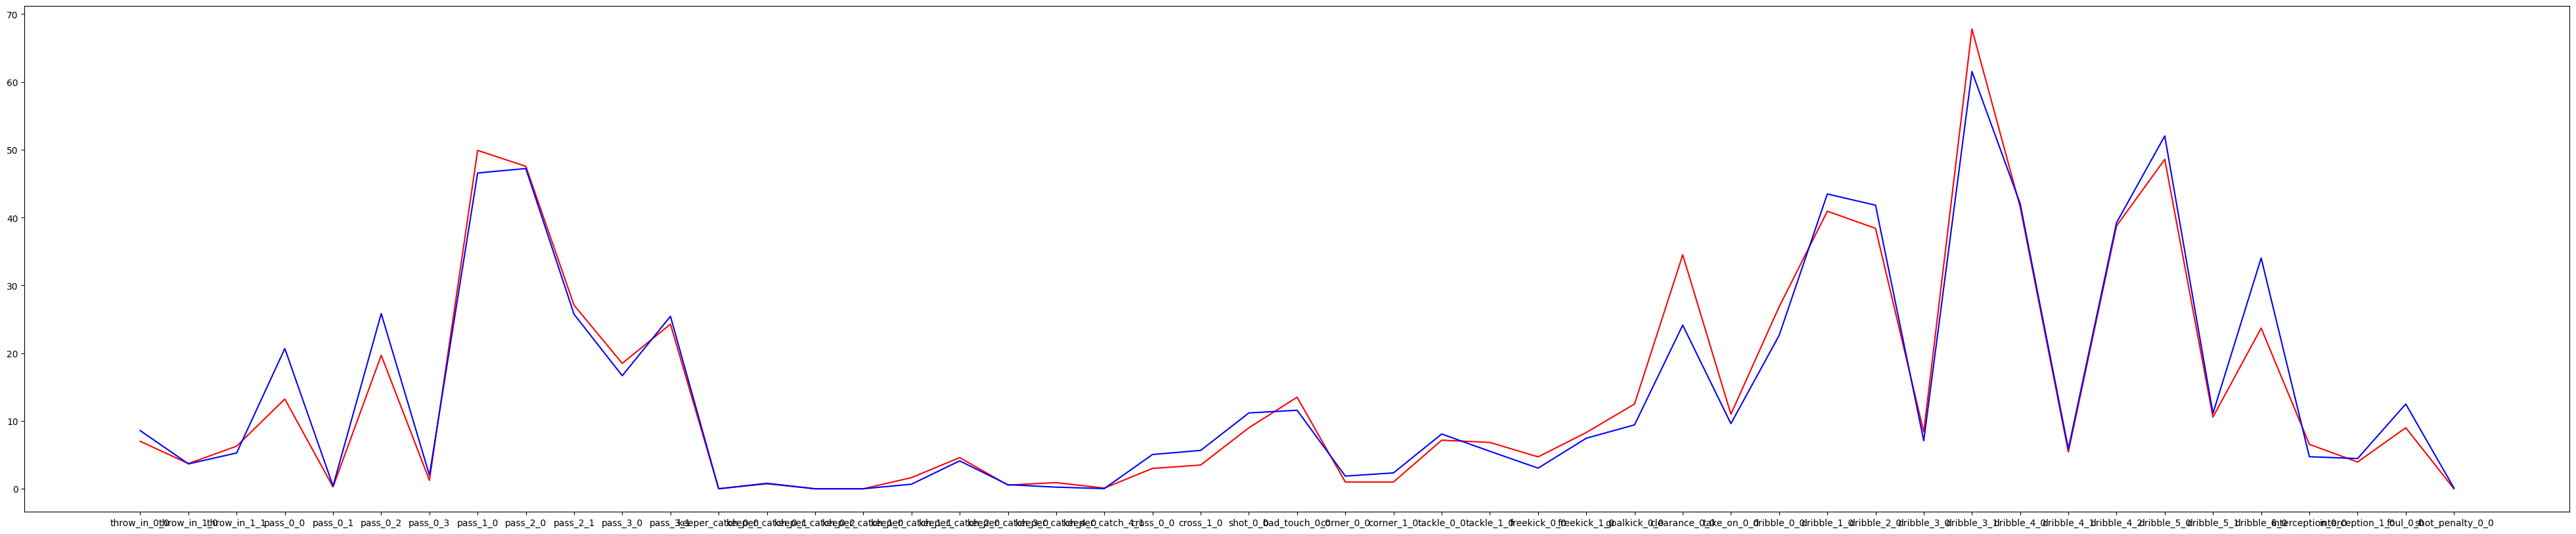

FC Machida Zelvia-Shonan Bellmare


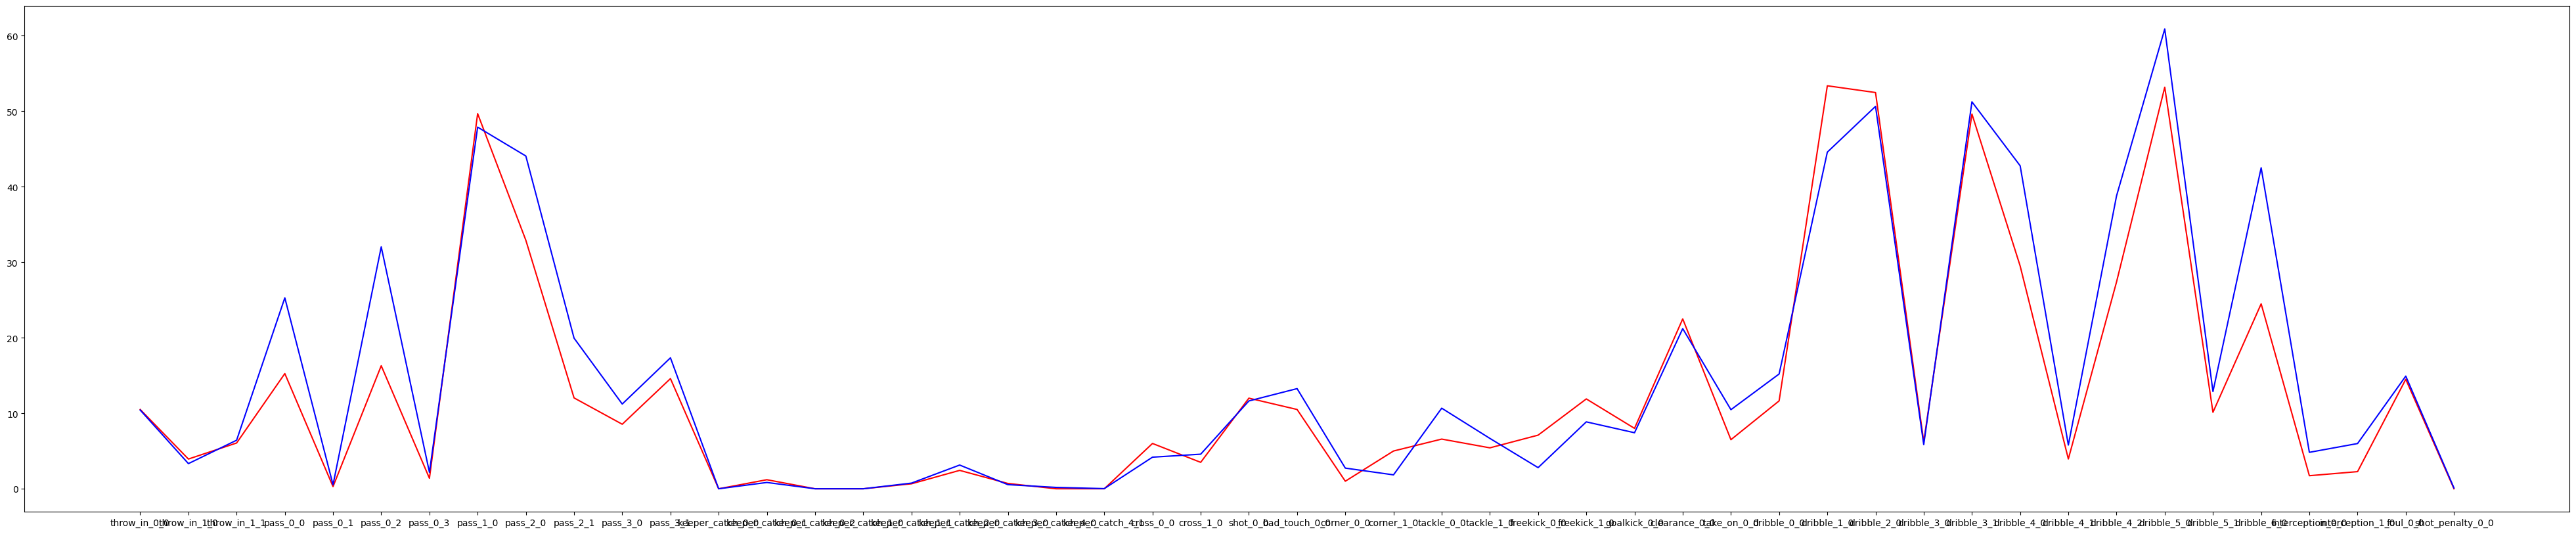

FC Machida Zelvia-Consadole Sapporo


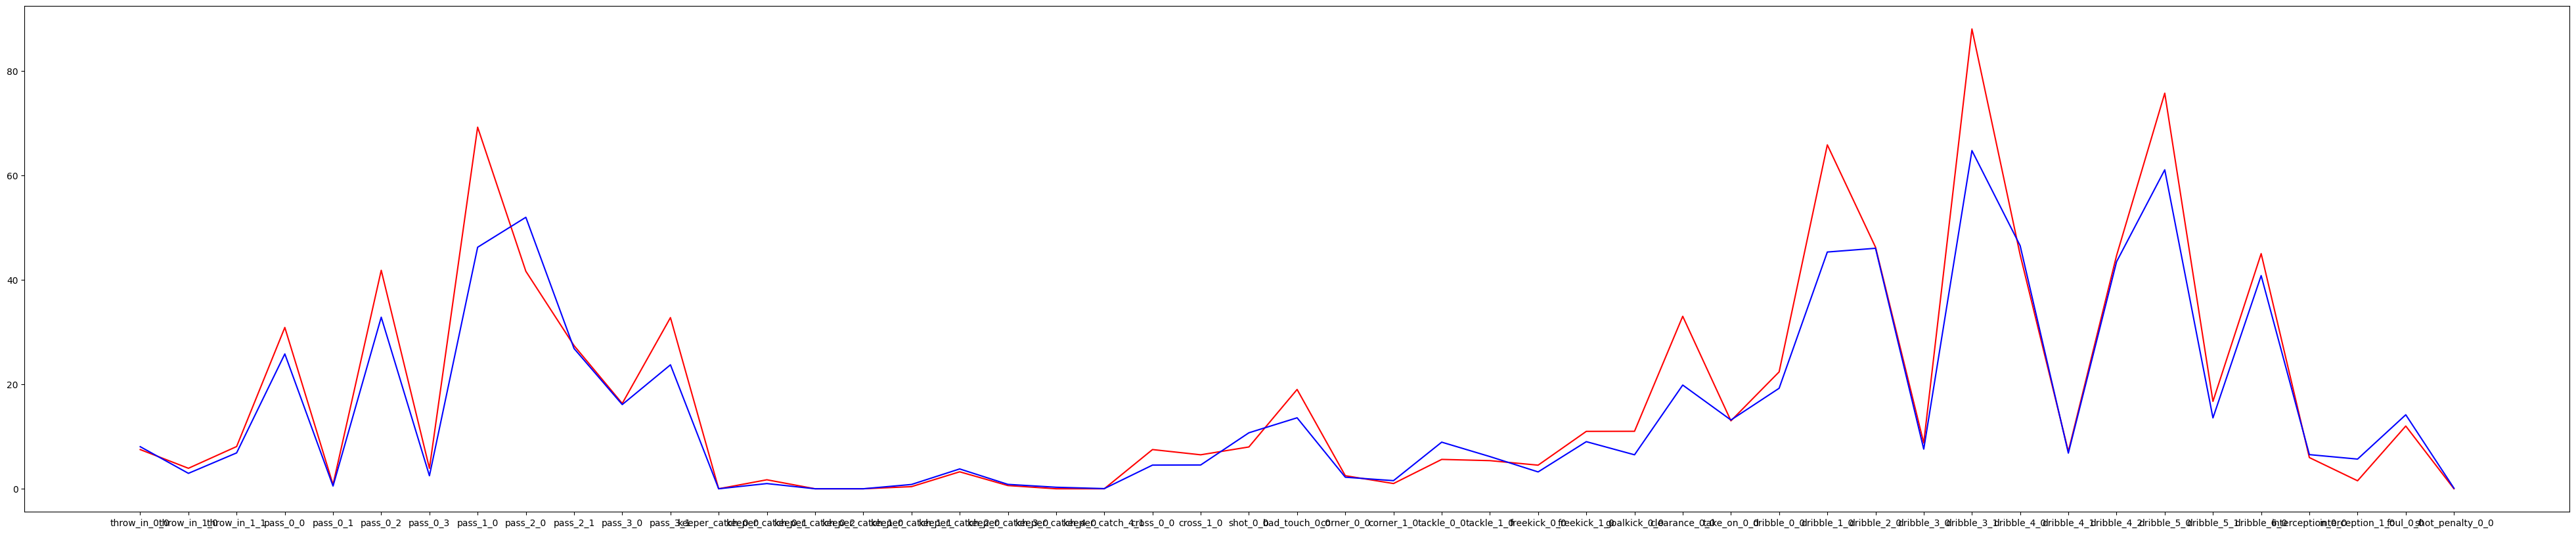

FC Machida Zelvia-Júbilo Iwata


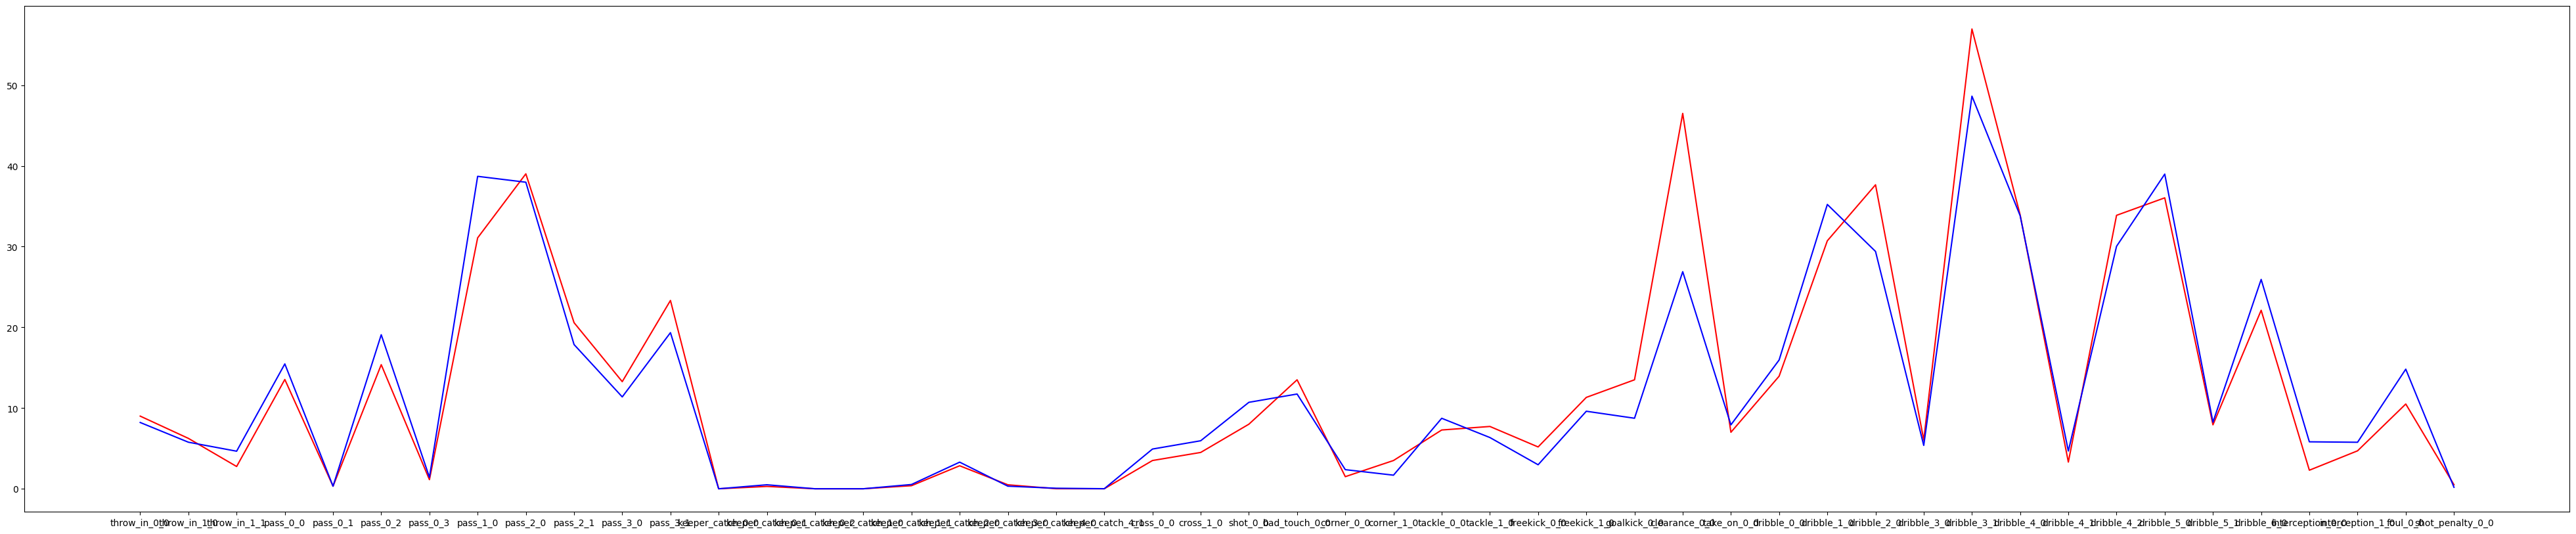

FC Machida Zelvia-Tokyo Verdy


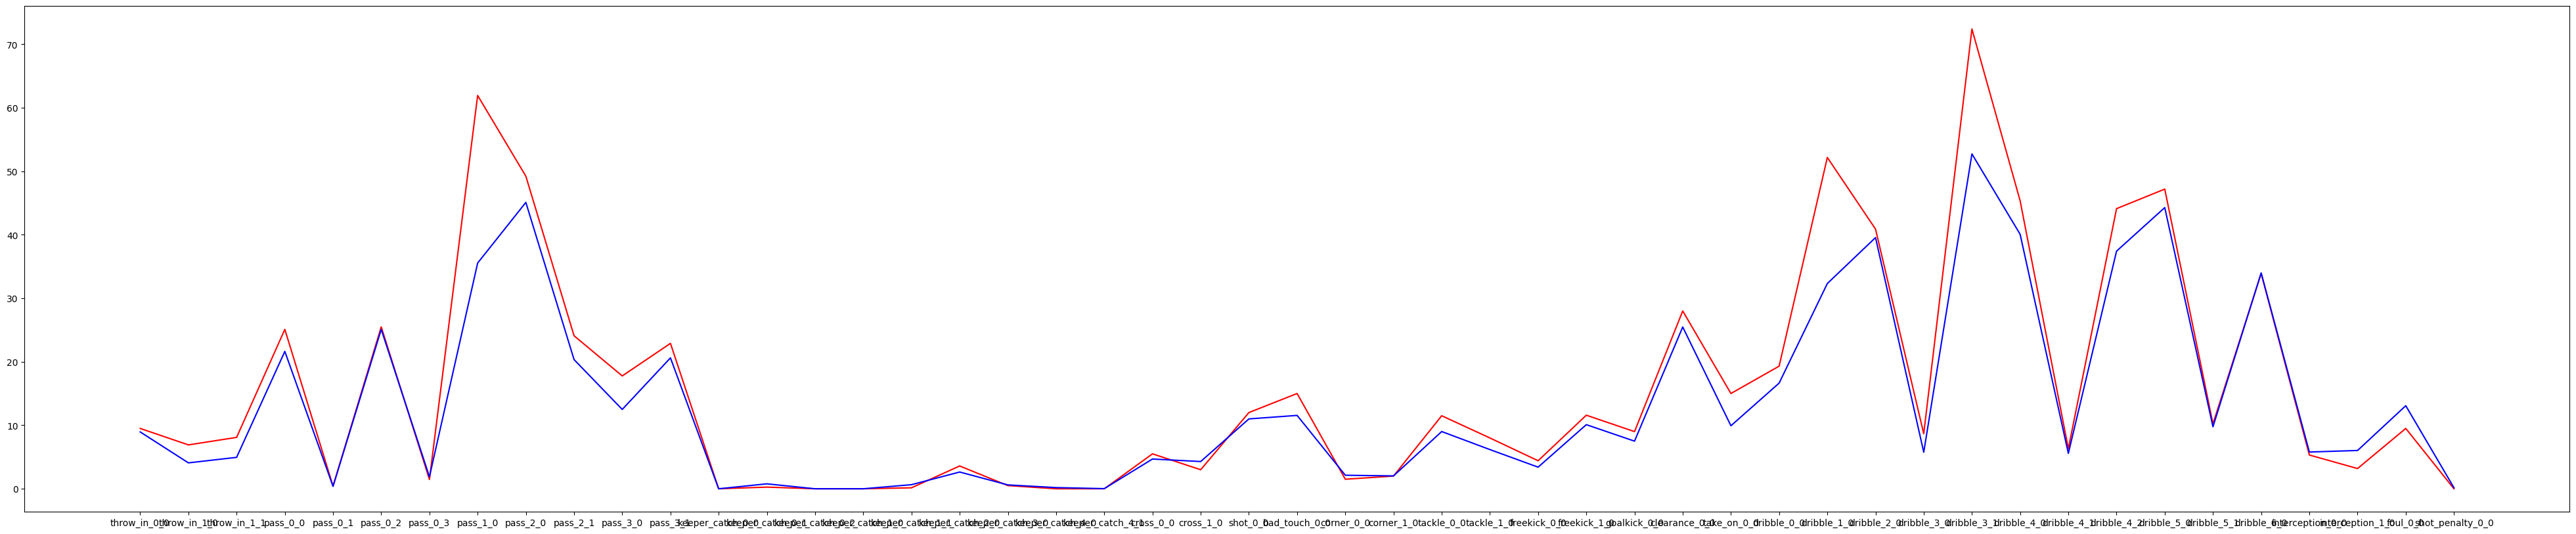

In [15]:
show_vectors(4609, set_teams, teams, vectors_pd)

In [17]:
mean_pd_machida = get_mean_difference_vector(4609)

throw_in 2
throw_in_0 1
throw_in_1 2


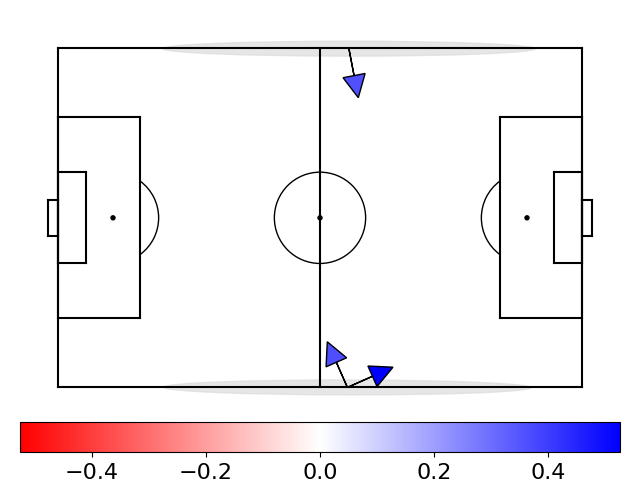

pass 7
pass_0 4
pass_1 1
pass_2 2
pass_3 2


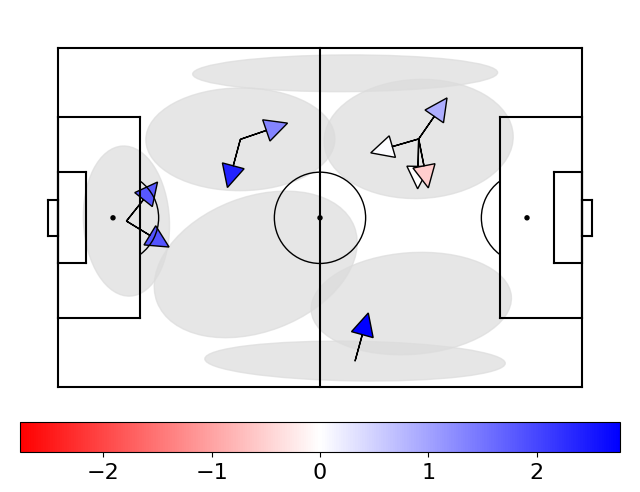

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


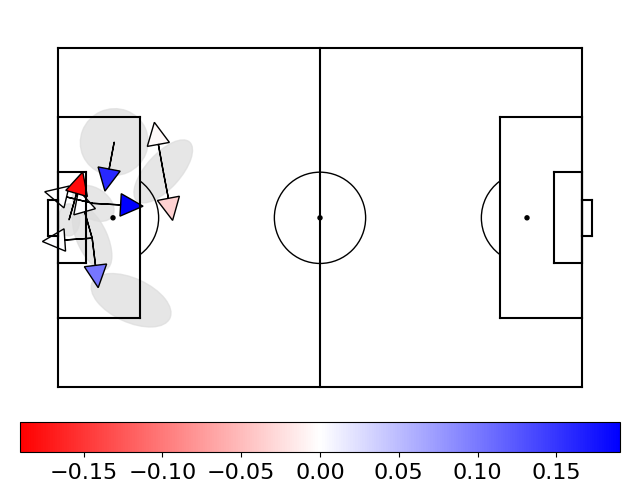

cross 2


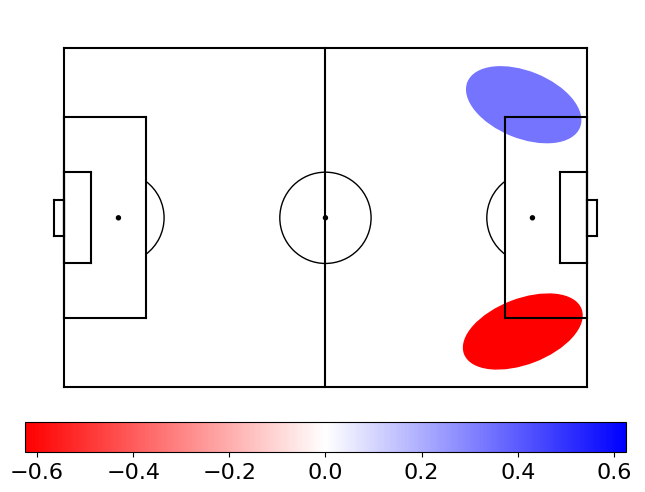

shot 1


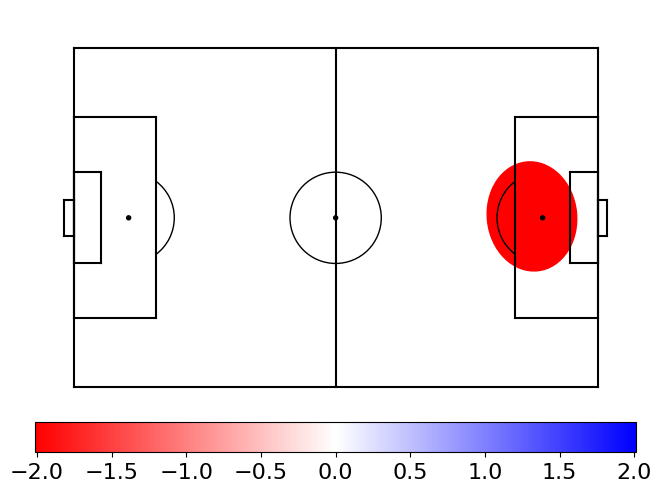

bad_touch 1


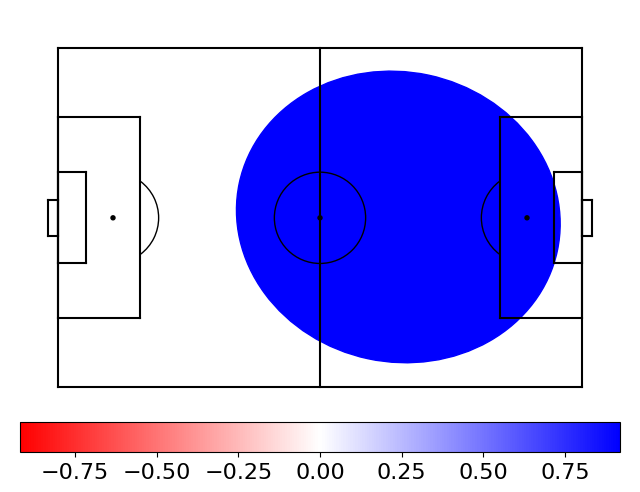

corner 2


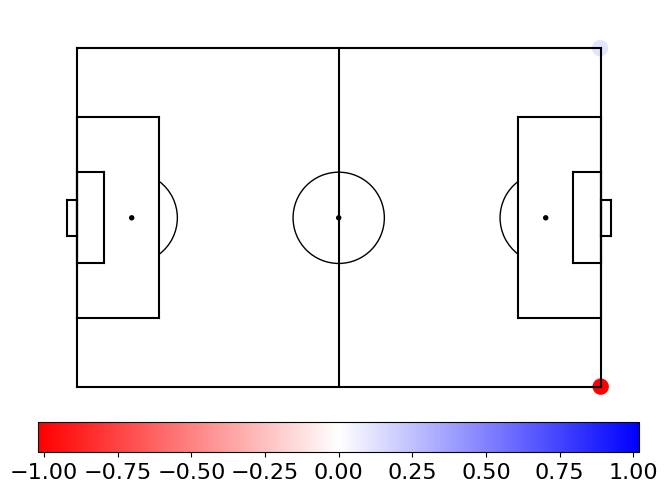

tackle 2


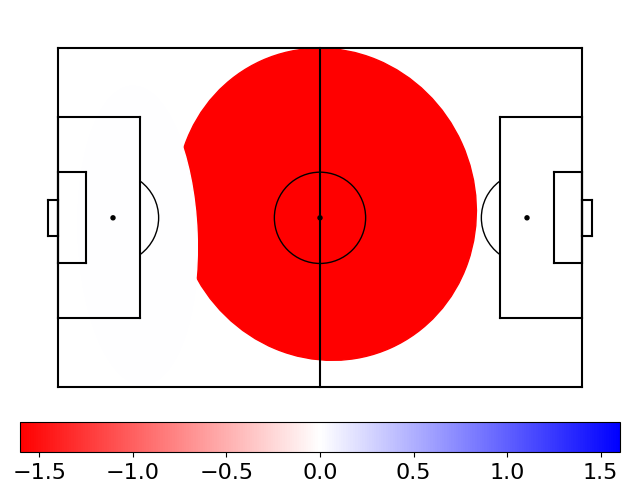

freekick 2


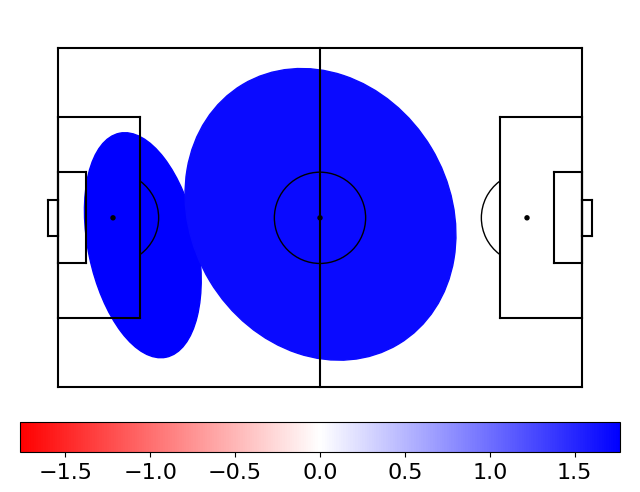

goalkick 1


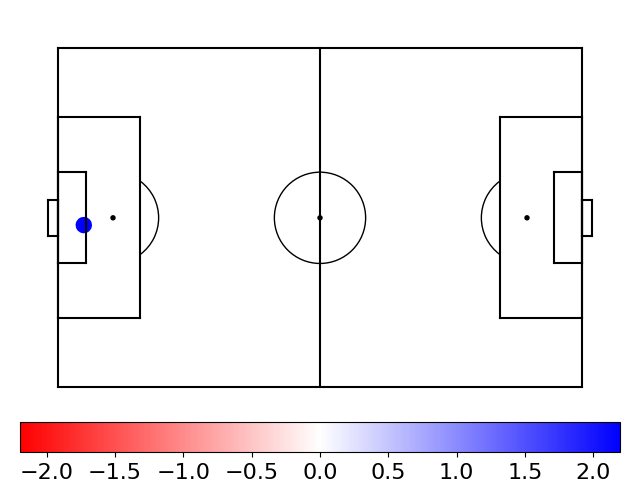

clearance 1


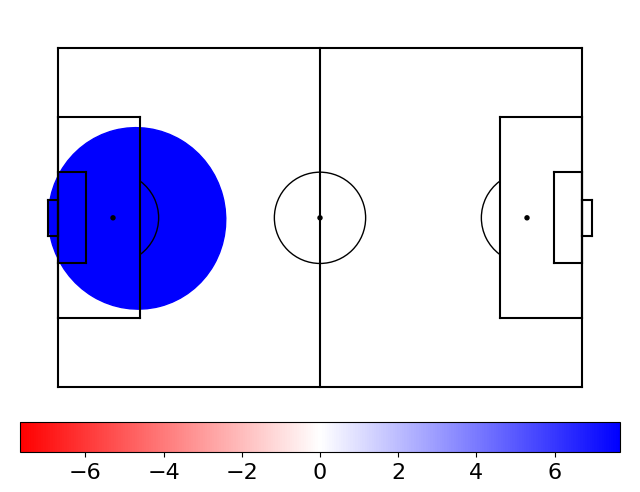

take_on 1


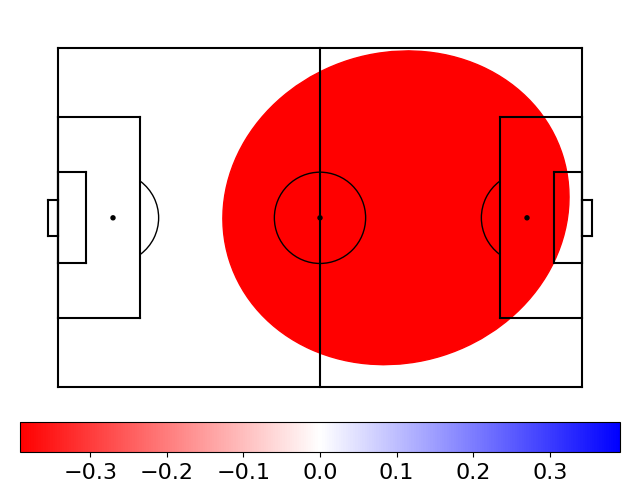

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


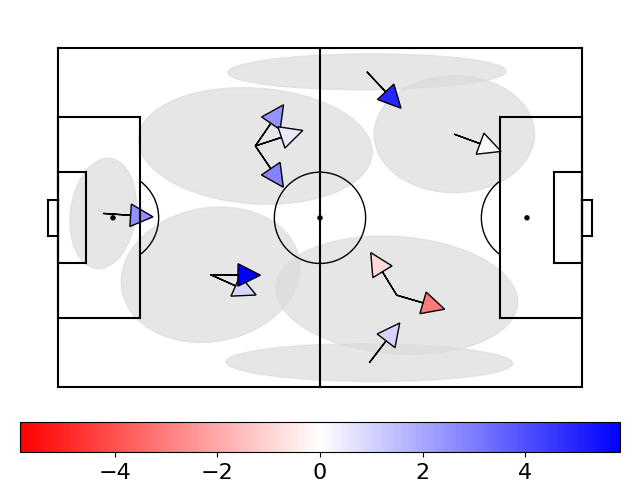

interception 2


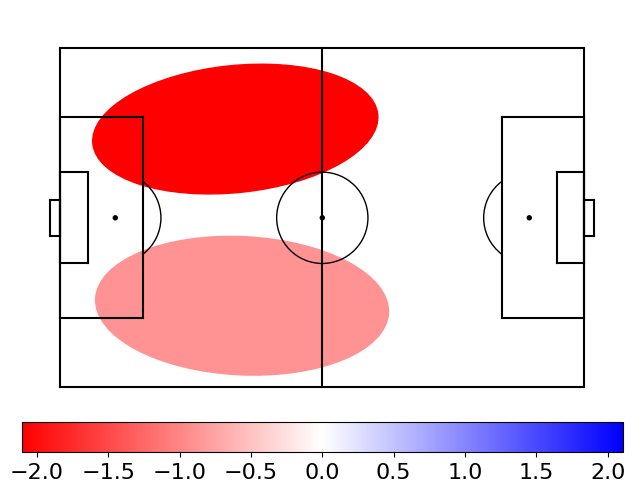

foul 1


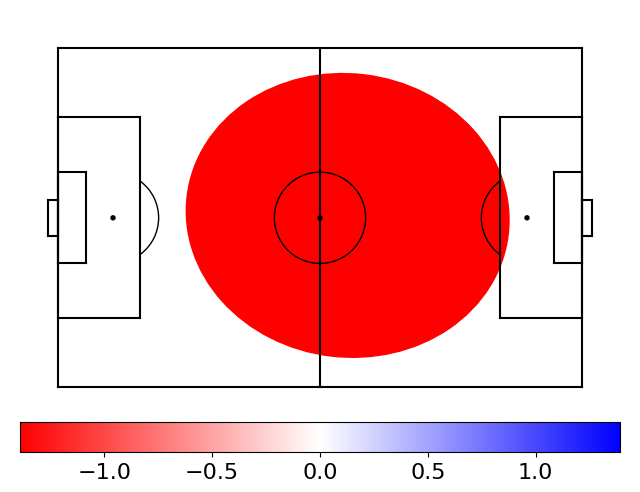

shot_penalty 1


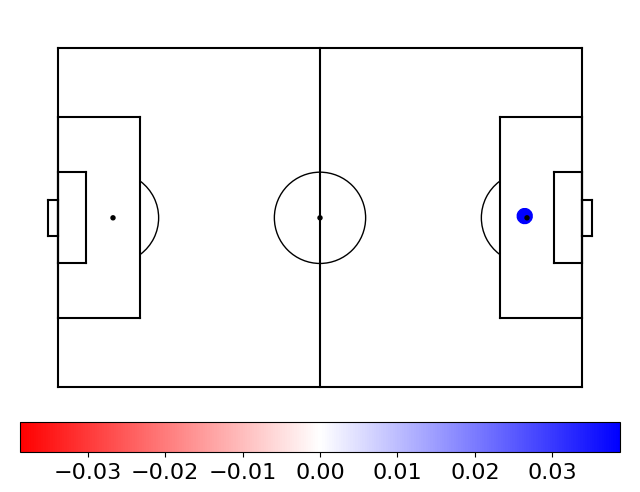

In [18]:
vis.show_component_differences(loc_models, dir_models, mean_pd_machida.loc[0], mean_pd_machida.loc[1], 'Machida Zelvia', 'all', save=False)